In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

import sys
sys.path.append("../scripts")
import data
import models
import utils
import experiments_new

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [82]:
SEED = 0

In [84]:
dataset = "german"
n_folds = 10
fold = 0
n_groups = 4

In [87]:
params = {
    "learning_rate" : 0.25,
    "max_depth" : 4,
    "min_child_weight" : 0.005,
    "multiplier_learning_rate" : 0.3,
    "reg_lambda" : 100
}

In [88]:
iters_list = list(range(5, 100, 5))

In [89]:
call_m2fgb = lambda x : models.M2FGB(fair_weight = 0.3, dual_learning = "gradient_norm", n_estimators=x, random_state= SEED, **params)
call_lgbm = lambda x : models.M2FGB(fair_weight = 0, n_estimators = x, random_state = SEED, **params)
def call_model(x, model_name):
    if model_name == "m2fgb":
        return call_m2fgb(x)
    elif model_name == "lgbm":
        return call_lgbm(x)

In [90]:
X_train, Y_train, X_val, Y_val, X_test, Y_test = data.get_fold(
    dataset, fold, n_folds, SEED
)
A_train, A_val, A_test = experiments_new.get_subgroup_feature(
    dataset, X_train, X_val, X_test, n_groups
)
X_train, X_val, X_test = data.preprocess_dataset(dataset, X_train, X_val, X_test)

{'Female_True': 0, 'Male_False': 1, 'Male_True': 2, 'Female_False': 3}


In [91]:
methods_names = ["lgbm", "m2fgb"]

In [92]:
score = {}
score["train"] = dict([(m, []) for m in methods_names])
score["test"] = dict([(m, []) for m in methods_names])
computing_time = dict([(m, 0) for m in methods_names])

for method in methods_names:
    for iter in iters_list:
        model = call_model(iter, method)
        start = time()
        model.fit(X_train, Y_train, A_train)
        end = time()

        computing_time[method] = end - start

        Y_pred = model.predict_proba(X_train)[:, 1]
        score["train"][method].append(utils.logloss_group(Y_train, Y_pred, A_train, "equalized_loss"))
        
        Y_pred = model.predict_proba(X_test)[:, 1]
        score["test"][method].append(utils.logloss_group(Y_test, Y_pred, A_test, "equalized_loss"))

    score["train"][method] = np.array(score["train"][method])
    score["test"][method] = np.array(score["test"][method])


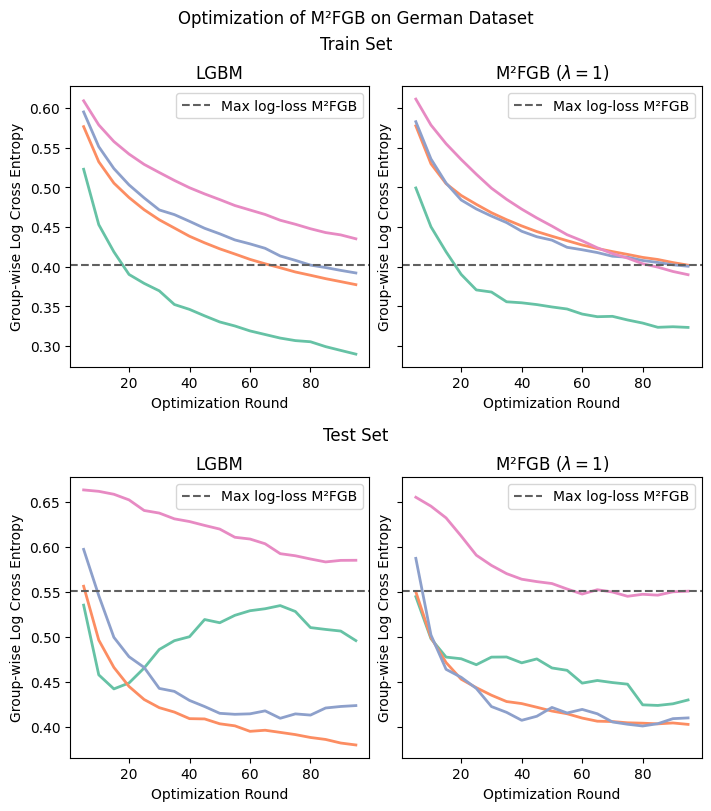

In [93]:
fig = plt.figure(constrained_layout=True, figsize = (7, 8))
fig.suptitle('Optimization of M²FGB on German Dataset')

subfigs = fig.subfigures(nrows=2, ncols=1)
sets = ["train", "test"]
set_names = ["Train Set", "Test Set"]
better_methods_names = {
    "lgbm" : "LGBM",
    "m2fgb" : "M²FGB ($\lambda = 1$)"
}
for row, subfig in enumerate(subfigs):
    subfig.suptitle(set_names[row])

    max_score = np.max(score[sets[row]]["m2fgb"][-1, :])
    axs = subfig.subplots(nrows=1, ncols=2, sharey=True)


    for col, ax in enumerate(axs):
        method = methods_names[col]

        ax.set_title(better_methods_names[method])

        # set color cycle to Pastel2
        ax.set_prop_cycle(color=plt.cm.Set2.colors)
        
        for ng in range(n_groups):
            ax.plot(iters_list, score[sets[row]][method][:, ng], lw = 2)


        ax.set_xlabel("Optimization Round")
        ax.set_ylabel("Group-wise Log Cross Entropy")

        ax.axhline(max_score, color = "#606060", linestyle = "--", label = "Max log-loss M²FGB")
        ax.legend()
        #ax.grid(True)

plt.savefig("../figs/convergence_german.pdf", dpi = 300)
plt.show()